In [1]:
import os
import gzip
import anndata
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dynamo as dyn
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)
dyn.get_all_dependencies_version()

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


package,umap-learn,pynndescent,python-igraph,numdifftools,seaborn,statsmodels,numba,dynamo-release,scikit-learn,cvxopt,pandas,scipy,numpy,networkx,pre-commit,colorcet,loompy,openpyxl,get-version,matplotlib,tqdm,setuptools
version,0.5.3,0.5.7,0.9.11,0.9.40,0.12.0,0.13.2,0.55.0,1.1.0,1.1.2,1.3.0,1.5.0,1.9.1,1.21.0,2.8.6,2.20.0,3.0.0,3.0.7,3.0.10,3.5.4,3.6.0,4.64.1,65.3.0


In [2]:
d = pd.read_csv("results/blastocyst_counts.transcripts.transcript_name.meta.tsv", sep="\t")
d.index = d["Cell"]
m1 = pd.read_csv("results/blastocyst_counts.transcripts.transcript_name.total.tsv", sep="\t", index_col=0)
m2 = pd.read_csv("results/blastocyst_counts.transcripts.transcript_name.nascent.tsv", sep="\t", index_col=0)

In [3]:
flags1 = (m1 > 0).sum(axis=1) > 10
flags2 = (m1 > 0).sum(axis=0) > 100
print(sum(flags1), sum(flags2))

10766 526


In [4]:
m3 = m1[flags1][m1.columns[flags2]]
m4 = m2[flags1][m2.columns[flags2]]

In [5]:
adata = anndata.AnnData(m3.T)
adata.layers["total"] = m3.T
adata.layers["new"] = m4.T
adata.obs["group"] = d["Strain"]
adata.obs["time"] = 3
adata.obs = adata.obs.merge(d, left_index=True, right_index=True)
dyn.pp.recipe_monocle(adata, tkey="time")
adata = adata[adata.obs["UMIs"] > 4000,]
adata = adata[adata.obs["TCRatio"] > 0.002,]

dyn.tl.dynamics(adata, model='stochastic', cores=3, NTR_vel=True)
dyn.tl.reduceDimension(adata)
dyn.tl.leiden(adata)
dyn.tl.hdbscan(adata)
dyn.tl.louvain(adata)

if False: # correct stream direction
    lineage_dict = {
        "TE-1": ["muralTE", "poralTE"], 
        "ICM-1": ["EPI", "PE"],
    }
    dyn.tl.gene_wise_confidence(adata, group='CellType', lineage_dict=lineage_dict, ekey="M_t", vkey="velocity_T")
    adata = adata[:,(adata.var["avg_prog_confidence"] > 0) & (adata.var["avg_mature_confidence"] > 0.5)]
    
dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
dyn.vf.VectorField(adata, basis='umap')

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> 
Dynamo detects your labelin

|-----------> plotting with basis key=X_umap
|-----------> skip filtering louvain by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap_rnd
|-----------> skip filtering louvain by stack threshold when stacking color because it is not a numeric type


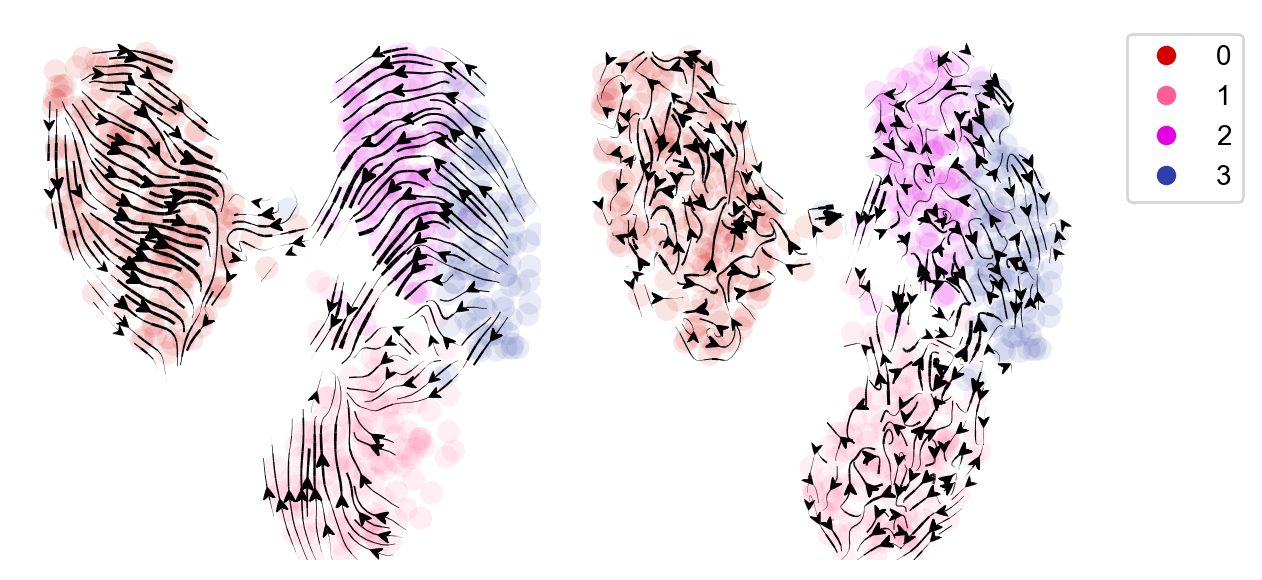

In [7]:
# color = "leiden"
color = "louvain"
# color = "CellType"
color_key = dict()
cts2 = ['poralTE', 'muralTE', 'TE-2', 'TE-1', 'ICM-1', 'ICM-2', 'PE', 'EPI']
colors2 = ["#839600", "#CD969B", "#C77CFF", "#00A9FF", "#00BE67", "#F8766D", "#00BFC4", "#86B414"]
for ct, c in zip(cts2, colors2):
    color_key[ct] = c
pointsize = 0.1

fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

dyn.pl.streamline_plot(adata, 
                       color=color, 
                       pointsize=pointsize, 
                       #color_key=color_key,
                       basis='umap', ax=axs[0], show_legend=False, save_show_or_return='return')

dyn.pl.streamline_plot(adata, 
                       color=color, 
                       pointsize=pointsize,
                       #color_key=color_key,
                       basis='umap_rnd', ax=axs[1], show_legend='right', save_show_or_return='return')

for ax in axs:
    ax.set_title(None)

plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/rna_velocity.isoform_based.png", dpi=300)
plt.close()